## Mapping the 2016 United Kingdom EU referendum by constituency

### Part 1: Creating United Kingdom base map

In [1]:
# Import modules
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

<b>Convert shapefile to dataframe</b>
<br>(https://geoportal.statistics.gov.uk/datasets/westminster-parliamentary-constituencies-december-2015-full-clipped-boundaries-in-great-britain/data)
<ul>
<li>pcon15nm is equal to constituency, which represents the UK’s voting boundaries</li>
<li>This base map doesn't contain Northern Ireland</li>
</ul>

In [2]:
# Open UK basemap shapefile and convert it to dataframe
map_df = gpd.read_file(os.path.join("data", "uk_generalized_2015.shp")).drop(["objectid"], axis=1
                                    ).rename(columns={"pcon15nm":"constituency"})
map_df.head()

,pcon15cd,constituency,st_areasha,st_lengths,geometry
0,E14000530,Aldershot,5.297815e+07,42197.629271,"POLYGON ((-0.77547 51.33196, -0.77533 51.33164..."
1,E14000531,Aldridge-Brownhills,4.401654e+07,38590.183714,"POLYGON ((-1.90508 52.64321, -1.90556 52.64290..."
2,E14000532,Altrincham and Sale West,5.092937e+07,47813.461413,"POLYGON ((-2.31599 53.43467, -2.31601 53.43454..."
3,E14000533,Amber Valley,1.246464e+08,64665.130033,"POLYGON ((-1.33164 53.08099, -1.33164 53.08080..."
4,E14000534,Arundel and South Downs,6.452509e+08,333618.028722,"MULTIPOLYGON (((-0.56262 51.05574, -0.56187 51..."


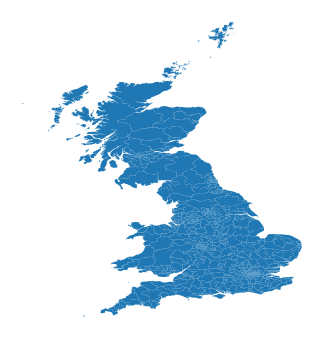

In [3]:
# Plot the UK base map
f, ax = plt.subplots(1, figsize=(6, 6))
ax = map_df.plot(ax=ax)

# Do not show axis
ax.set_axis_off()

### Part 2: Sorting estimates of leave vote in Westminster constituencies

This table shows the state of the parties in each constituency as at the 2016 United Kingdom European Union membership referendum. (https://docs.google.com/spreadsheets/d/1wTK5dV2_YjCMsUYlwg0l48uWWf44sKgG8uFVMv5OWlA/edit#gid=893960794)

<ul>
<li><b>PCON11CD</b> is the same as pcon15cd</li>
<li><b>Figure to use</b> is the final leave proportion</li>
<li>This dataset doesn't contain Northern Ireland</li>
</ul>

Therefore, let's clean up the raw data by deleting unnecessary columns and renaming the columns.

In [4]:
# Convert estimates of leave vote csv file and convert it to dataframe
# Get rid of all columns except constituency ID [pcno15cd] and leave proportion
data_df = pd.read_csv(os.path.join("data", "Revised estimates of leave vote in Westminster constituencies - demog_based_estimates.csv")
                     ).drop(columns=["refno", "Estimated Leave proportion", "Known result", "Notes", "Errors", "Unnamed: 9", "Constituency", "Region"]
                           ).rename(columns={"PCON11CD":"pcon15cd", "Figure to use":"Leave proportion"})
data_df.head()

,pcon15cd,Leave proportion
0,E14000752,0.249829
1,E14001008,0.224284
2,S14000023,0.217955
3,E14000602,0.207115
4,E14000720,0.209496


Considering the leave proportion, the next step is to decide <b>MP Position</b>, which means if leave proportion is greater than 0.5, this constituency supports <b>Leave</b>, otherwise <b>Remain</b>.<br>

>Create two new columns named <i>Remain %</i> and <i>Leave %</i> based on <i>Leave proportion</i>.

In [5]:
# Calculate the precentage of Remain and leave
# Round the number
data_df["Remain %"] = round((1 - data_df["Leave proportion"]) * 100, 2)
data_df["Leave %"] = round(data_df["Leave proportion"] * 100, 2)
data_df.head()

,pcon15cd,Leave proportion,Remain %,Leave %
0,E14000752,0.249829,75.02,24.98
1,E14001008,0.224284,77.57,22.43
2,S14000023,0.217955,78.20,21.80
3,E14000602,0.207115,79.29,20.71
4,E14000720,0.209496,79.05,20.95


>Decide <b>MP Position</b> by Leave proportion

In [6]:
# Decide the MP Position by Leave proportion
# If leave proportion is greate than 0.5 ==> Leave, otherwise Remain
data_df.loc[data_df["Leave proportion"]< 0.5,"MP Position"] = "Remain"
data_df.loc[data_df["Leave proportion"]> 0.5,"MP Position"] = "Leave"

data_df.head()

,pcon15cd,Leave proportion,Remain %,Leave %,MP Position
0,E14000752,0.249829,75.02,24.98,Remain
1,E14001008,0.224284,77.57,22.43,Remain
2,S14000023,0.217955,78.20,21.80,Remain
3,E14000602,0.207115,79.29,20.71,Remain
4,E14000720,0.209496,79.05,20.95,Remain


>Join vote results to United Kingdom boundary by constituency

In [7]:
# Join UK basemap dataframe to voting result dataframe based on key [pcon15cd]
df_new = map_df.merge(data_df)

# Sort rows by Leave proportion from low to high (Strongly support Remain to Strongly support Leave)
df_sorted = df_new.sort_values(by=["Leave proportion"])
df_sorted.head()

,pcon15cd,constituency,st_areasha,st_lengths,geometry,Leave proportion,Remain %,Leave %,MP Position
426,E14000978,Streatham,1.044553e+07,18955.480471,"POLYGON ((-0.11567 51.46124, -0.11569 51.46120...",0.205397,79.46,20.54,Remain
115,E14000602,Bristol West,1.724600e+07,22627.645373,"MULTIPOLYGON (((-2.57953 51.48509, -2.57949 51...",0.207115,79.29,20.71,Remain
222,E14000720,Hackney North and Stoke Newington,9.062135e+06,15694.437211,"POLYGON ((-0.04508 51.56176, -0.04491 51.56151...",0.209496,79.05,20.95,Remain
334,E14000763,Islington North,7.380399e+06,14387.758713,"POLYGON ((-0.10618 51.56554, -0.10485 51.56464...",0.216111,78.39,21.61,Remain
584,S14000031,Glasgow North,1.685333e+07,27281.179061,"POLYGON ((-4.26364 55.91848, -4.26448 55.91827...",0.216205,78.38,21.62,Remain


**Use a function to create geographic maps**

In [8]:
def geographic_map(dataframe, column, dic, label_placement, fontsize, plot_title):
    # Plot data
    fig, ax = plt.subplots(figsize=(10, 10))

    handles = []

    # Loop through each attribute type and plot it using the colors assigned in the dictionary
    for ctype, data in dataframe.groupby(column):

        # Define the color and labels for each group using the dictionary
        color = dic[ctype]
        label = ctype

        # Plot each group using the color defined above
        data.plot(color = color, ax = ax)

        # Create labels for each group and append them to handles
        handle = mpatches.Patch(label = label, color = color)
        handles.append(handle)
    
    # Set legend and title
    # bbonx_to_anchor: set the absolute position of legend 
    # prop: font size
    ax.legend(bbox_to_anchor = label_placement, prop={'size': fontsize}, handles = handles)
    ax.set(title = plot_title)

    ax.set_axis_off()
    plt.show()

>Plot color by attribute: Yellow for Remain & Blue for Leave

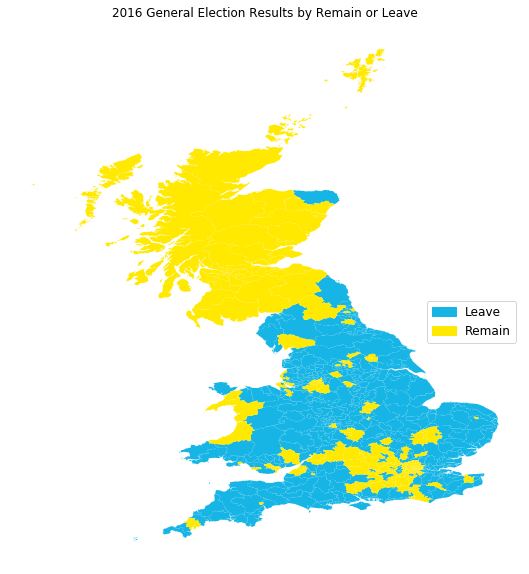

In [9]:
# Create a dictionary to assign each attribute value to a particular color
Palette = {"Remain": "#FFE900",
            "Leave": "#16B5E5"}

plot_title = "2016 General Election Results by Remain or Leave"

fontsize = 12

label_placement = (1, 0.5)

geographic_map(df_new, "MP Position", Palette, label_placement, fontsize, plot_title)

### Part 3 : Adding pro-Brexit and pro-referendum parties

I want to plot the first party and their attitude towards Brexit combined with MP Position.
<br>(https://commonslibrary.parliament.uk/research-briefings/cbp-7979/)
<br><b>Note that this database contains Northern Ireland which does not exist in basemap.</b>

In [10]:
# Open the first party csv
rawdata_df = pd.read_csv(os.path.join("data", "HoC-GE2017-constituency-results.csv"))

# Exclude data of Northern Ireland
noireland_df = rawdata_df.loc[rawdata_df["country_name"] != "Northern Ireland"]

# Create new dataframe only including pcon15cd and first_party
party_df = rawdata_df[["ons_id", "first_party"]].rename(
            columns={"ons_id":"pcon15cd"})

party_df.head()

,pcon15cd,first_party
0,W07000049,Lab
1,W07000058,Con
2,S14000001,SNP
3,S14000002,Con
4,S14000003,SNP


The next step is to add a new column based on first party's attitude toward Brexit. 
>The only <b>pro-Brexit</b> party is <i>Conservative</i>. 

In [11]:
# list all the parties using .unique()
partylist = list(party_df["first_party"].unique())

partylist

['Lab', 'Con', 'SNP', 'PC', 'LD', 'DUP', 'SF', 'Green', 'Spk', 'Ind']

In [12]:
# Add a new column to decide whether first party is pro-Brexit or pro-referendum
party_df["Party position"] = np.where(party_df["first_party"] == "Con", "pro-Brexit", "pro-referendum")
party_df.head()

,pcon15cd,first_party,Party position
0,W07000049,Lab,pro-referendum
1,W07000058,Con,pro-Brexit
2,S14000001,SNP,pro-referendum
3,S14000002,Con,pro-Brexit
4,S14000003,SNP,pro-referendum


Merge it to the base map and create another new column for results:
<ol>There're <b>5</b> different results:
<li>Seats won by pro-Brexit parties, where they also received most votes</li>
<li>Seats won by pro-Breixt parties, where pro-referendum parties received more votes</li>
<li>Seats won by pro-referendum parties, where they also received most votes</li>
<li>Seats won by pro-referendum parties, where pro-Brexit parties received more votes</li>
<li>Seats won by pro-referendum Speaker</li>
</ol>

In [13]:
# Join frist party dataframe to UK basemap dataframe
df_merge = df_new.merge(party_df)

# Define a function to assgin different values to election results
def election_result(row):
    if row["MP Position"] == "Leave" and row["Party position"] == "pro-Brexit":
        return 1
    elif row["MP Position"] == "Leave" and row["Party position"] == "pro-referendum":
        return 2
    elif row["MP Position"] == "Remain" and row["Party position"] == "pro-referendum" and row["first_party"] != "Spk":
        return 3
    elif row["MP Position"] == "Remain" and row["Party position"] == "pro-Brexit":
        return 4
    elif row["first_party"] == "Spk":
        return 5

# Append a new column with election results generated above
df_merge["result"] = df_merge.apply(election_result, axis=1)
df_merge.head()

,pcon15cd,constituency,st_areasha,st_lengths,geometry,Leave proportion,Remain %,Leave %,MP Position,first_party,Party position,result
0,E14000530,Aldershot,5.297815e+07,42197.629271,"POLYGON ((-0.77547 51.33196, -0.77533 51.33164...",0.578978,42.10,57.90,Leave,Con,pro-Brexit,1
1,E14000531,Aldridge-Brownhills,4.401654e+07,38590.183714,"POLYGON ((-1.90508 52.64321, -1.90556 52.64290...",0.677963,32.20,67.80,Leave,Con,pro-Brexit,1
2,E14000532,Altrincham and Sale West,5.092937e+07,47813.461413,"POLYGON ((-2.31599 53.43467, -2.31601 53.43454...",0.384687,61.53,38.47,Remain,Con,pro-Brexit,4
3,E14000533,Amber Valley,1.246464e+08,64665.130033,"POLYGON ((-1.33164 53.08099, -1.33164 53.08080...",0.653392,34.66,65.34,Leave,Con,pro-Brexit,1
4,E14000534,Arundel and South Downs,6.452509e+08,333618.028722,"MULTIPOLYGON (((-0.56262 51.05574, -0.56187 51...",0.506854,49.31,50.69,Leave,Con,pro-Brexit,1


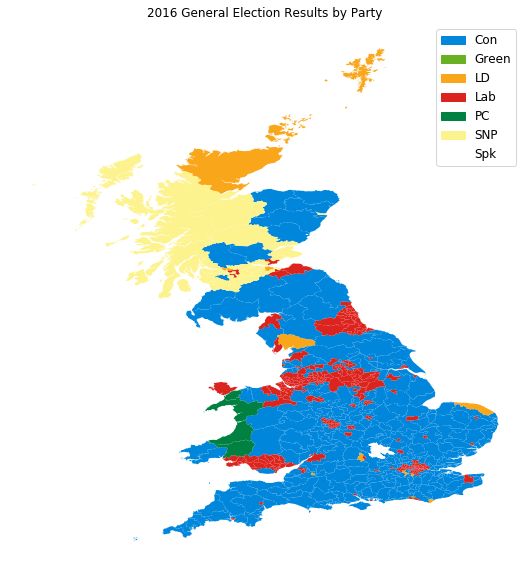

In [14]:
# Create a dictionary to assign each attribute value to a particular color and label
Palette = { "Lab": "#DC241F",
        "Con": "#0087DC",
        "SNP": "#FDF38E",
        "PC": "#008142", 
        "LD": "#FAA61A",
        "DUP": "#D46A4C",
        "SF": "#326760",
      "Green":"#6AB023",
        "Spk": "#FFFFFF",
        "Ind": "#70147A"}

plot_title = "2016 General Election Results by Party"

fontsize = 12

label_placement = (1, 1)

# Use the function created above
geographic_map(df_merge, "first_party", Palette, label_placement, fontsize, plot_title)

>Plot color by attribute: 
<ul>
<li><b>Dark Bule</b>: Seats won by pro-Brexit parties, where they also received most votes</li>
<li><b>Light Bule</b>: Seats won by pro-Brexit parties, where pro-referendum parties received more votes</li>
<li><b>Dark Yellow</b>: Seats won by pro-referendum parties, where they also received most votes</li>
<li><b>Light Yellow</b>: Seats won by pro-referendum parties, where pro-Brexit parties received more votes</li>
<li><b>Black</b> :Seats won by pro-referendum Speaker</li>
</ul>

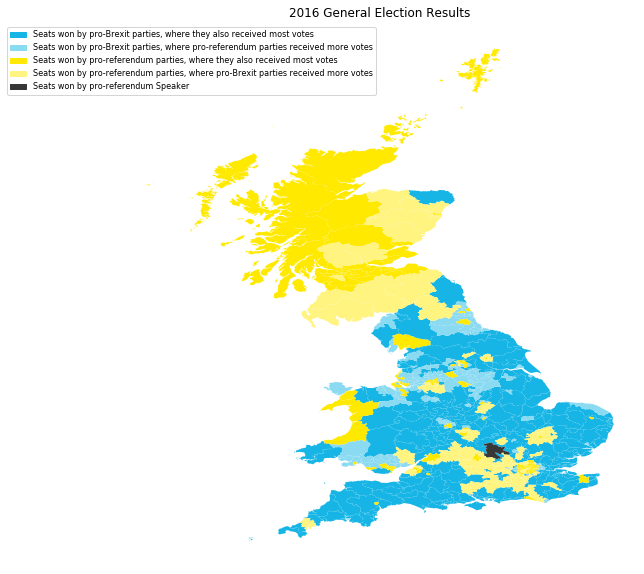

In [15]:
# Create a dictionary to assign each attribute value to a particular color and label
dic = { 1: ["#16B5E5","Seats won by pro-Brexit parties, where they also received most votes"],
        2: ["#8ADAF2", "Seats won by pro-Brexit parties, where pro-referendum parties received more votes"],
        3: ["#FFE900","Seats won by pro-referendum parties, where they also received most votes"], 
        4: ["#FFF47F", "Seats won by pro-referendum parties, where pro-Brexit parties received more votes"],
        5: ["#373737", "Seats won by pro-referendum Speaker"]}

# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

handles = []

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for code, data in df_merge.groupby("result"):
    
    # Define the color for each group using the dictionary
    color = dic[code][0]
    label = dic[code][1]
    
    # Plot each group using the color defined above
    data.plot(color = color, ax = ax, linewidth = 2, legend=True)
    
    # Create labels for each group and append them to handles
    handle = mpatches.Patch(label = label, color = color)
    handles.append(handle)

# Set legend and title
# bbonx_to_anchor: set the absolute position of legend 
# prop: font size    
ax.legend(bbox_to_anchor=(0.5, 1), prop={'size': 8}, handles = handles)

ax.set(title = "2016 General Election Results")

ax.set_axis_off()
plt.show()

### Part 4: Creating Hexmap

Compared to choropleth map, hexmap contains Northern Ireland.
    <br>(https://odileeds.org/projects/petitions/?241584)
<br>The coordinate system <b>“odd-r”(pointy-topped)</b> of hexagon represents horizontal layout shoves odd rows right. 
    <br>(https://www.redblobgames.com/grids/hexagons/#coordinates)

In [16]:
# Convert hex coordinates csv to dataframe
hex_df = pd.read_csv(os.path.join("data", "uk_hex.csv")).drop(
            columns=["Electorate", "Population"]).rename(columns={"Constituency":"constituency"})

hex_df.head()

,constituency,q,r
0,Aberavon,-12,-8
1,Aberconwy,-12,0
2,Aberdeen North,-4,25
3,Aberdeen South,-3,24
4,Airdrie and Shotts,-7,20


In [17]:
# Combine hexmap coordinate system data with general results(without Northernland)
df_drop = df_merge.drop(columns=["st_areasha", "st_lengths", "geometry", "pcon15cd"])

# Combine hex coordinates data with above data
hex_merge = df_drop.merge(hex_df)

hex_merge.head()

,constituency,Leave proportion,Remain %,Leave %,MP Position,first_party,Party position,result,q,r
0,Aldershot,0.578978,42.10,57.90,Leave,Con,pro-Brexit,1,-3,-11
1,Aldridge-Brownhills,0.677963,32.20,67.80,Leave,Con,pro-Brexit,1,-3,-1
2,Altrincham and Sale West,0.384687,61.53,38.47,Remain,Con,pro-Brexit,4,-7,3
3,Amber Valley,0.653392,34.66,65.34,Leave,Con,pro-Brexit,1,0,2
4,Arundel and South Downs,0.506854,49.31,50.69,Leave,Con,pro-Brexit,1,0,-15


>Add Northern Ireland election result to hexmap data

In [18]:
# Include data for Northern Ireland
ireland_df = rawdata_df.loc[rawdata_df["country_name"] == "Northern Ireland"]

# Create new dataframe only including constituency_name and first_party of Northern Ireland
party_ireland = ireland_df[["constituency_name", "first_party"]].rename(
            columns={"constituency_name":"constituency"})

# Add a new column to decide whether first party is pro-Brexit or pro-referendum
party_ireland["Party position"] = np.where(party_ireland["first_party"] == "Con", "pro-Brexit", "pro-referendum")

party_ireland.head()

,constituency,first_party,Party position
34,Belfast East,DUP,pro-referendum
35,Belfast North,DUP,pro-referendum
36,Belfast South,DUP,pro-referendum
37,Belfast West,SF,pro-referendum
189,East Antrim,DUP,pro-referendum


In [19]:
# Open ireland voting result csv as dataframe
ire_position = pd.read_csv(os.path.join("data", "ireland.csv")).rename(
                    columns={"Constituency":"constituency", "Leave":"Leave proportion"})

# Add columns for MP Position, the precentage of Remain and Leave
ire_position["MP Position"] = np.where(ire_position["Remain"] > 0.5, "Remain", "Leave")
ire_position["Remain %"] = round((1 - ire_position["Leave proportion"]) * 100, 2)
ire_position["Leave %"] = round(ire_position["Leave proportion"] * 100, 2)

# output selected columns to ire_atti dataframe
ire_atti = ire_position[["constituency", "Leave proportion", "Remain %", "Leave %", "MP Position"]]
ire_atti.head()

,constituency,Leave proportion,Remain %,Leave %,MP Position
0,Belfast East,0.514,48.6,51.4,Leave
1,Belfast North,0.496,50.4,49.6,Remain
2,Belfast South,0.305,69.5,30.5,Remain
3,Belfast West,0.259,74.1,25.9,Remain
4,East Antrim,0.552,44.8,55.2,Leave


In [20]:
# Combine Ireland voting result with Ireland first party dataframe
ireland_merge = ire_atti.merge(party_ireland)

# Add result column to Northern Ireland election result
ireland_merge["result"] = ireland_merge.apply(election_result, axis=1)

# Combine Ireland data with hex coordinates data
hex_ireland = ireland_merge.merge(hex_df)

# Combine Ireland data with whole map data 
hex_whole = hex_merge.append(hex_ireland, ignore_index=True
                            ).rename(columns={"first_party":"Party"})

hex_whole.head()

,constituency,Leave proportion,Remain %,Leave %,MP Position,Party,Party position,result,q,r
0,Aldershot,0.578978,42.10,57.90,Leave,Con,pro-Brexit,1,-3,-11
1,Aldridge-Brownhills,0.677963,32.20,67.80,Leave,Con,pro-Brexit,1,-3,-1
2,Altrincham and Sale West,0.384687,61.53,38.47,Remain,Con,pro-Brexit,4,-7,3
3,Amber Valley,0.653392,34.66,65.34,Leave,Con,pro-Brexit,1,0,2
4,Arundel and South Downs,0.506854,49.31,50.69,Leave,Con,pro-Brexit,1,0,-15


To create the hexmap for UK, I looped over each constituency to draw the hexagon and assign particular color by attribute.

Text(0.5, 0.98, '2016 General Election results: pro-Brexit vs. pro-referendum parties')

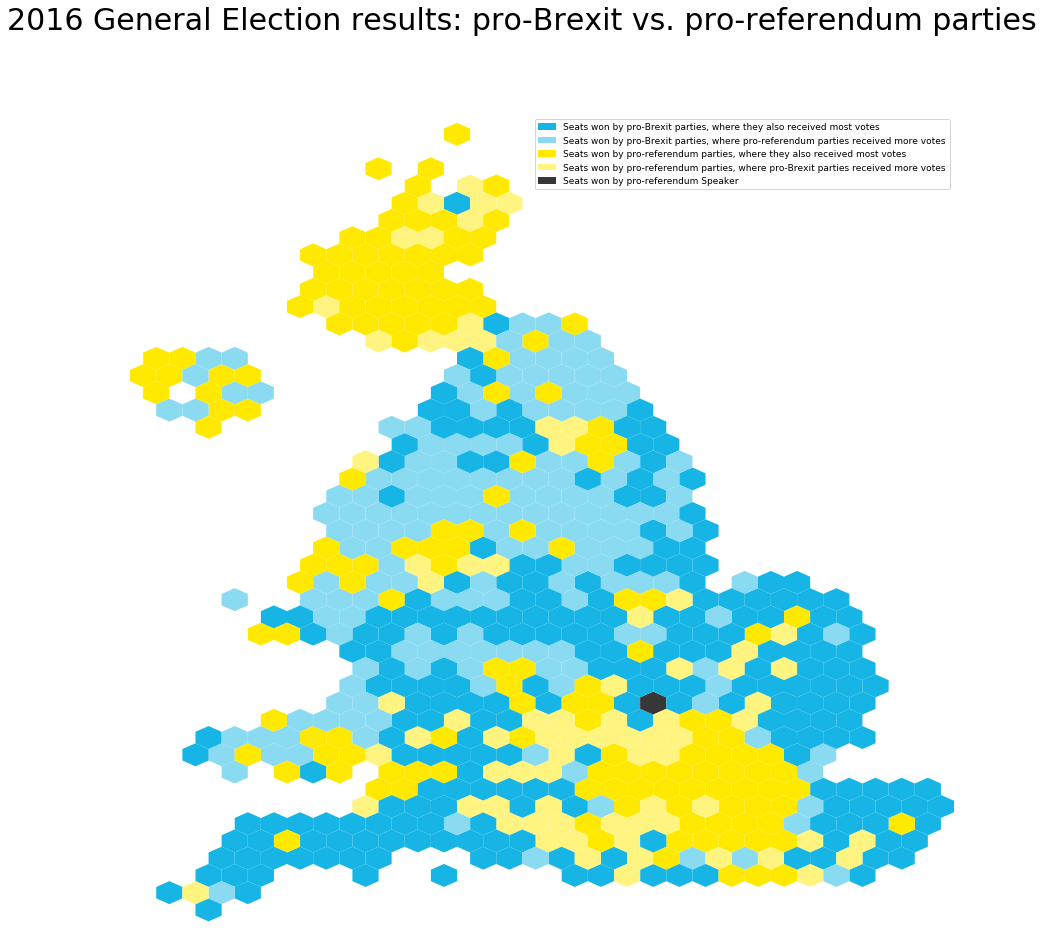

In [21]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
import matplotlib.colors
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, figsize=(15, 15))
ax.axis("off")

# Define the upper and lower boundary lines
y_min = 1000
y_max = -1000

# Define the radius and the difference between y coordinate of each hexagon
d = 0.5 / np.sin(np.pi / 3)
y_diff = np.sqrt(1 - 0.5 ** 2)
patches = []
colors = []

# Iterate through the constituencies
# and create hexagon for each constituency by RegularPolygon
# Assign hex x-coordinate(q), y-coordinate(r), election result(result) to new variables
for i in range(hex_whole.shape[0]):
    r = hex_whole.loc[i, "r"]
    q = hex_whole.loc[i, "q"]
    c = hex_whole.loc[i, "result"]

    # For further explanation, please refer to the well-written document listed above. 
    # It's hard to explain it clearly with just few words.
    if r % 2 == 1:
        # if in an odd row, we need to shift right
        q = q + 0.5
    r = y_diff * r
    
    # Create hexagon based on hex coordinates
    hexagon = RegularPolygon((q, r), numVertices = 6, radius = d, edgecolor = "#F2F2F2")
    # Group hexagons
    patches.append(hexagon)
    # Append colors to each hexagons
    colors.append(c)

    # Get plot boundary limitations
    if r < y_min:
        y_min = r - 1.0
    if r > y_max:
        y_max = r + 1.0

# Define the left and right boundary lines based on the most left and most right x-coordinates
x_min = hex_whole["q"].min() - 1.0
x_max = hex_whole["q"].max() + 1.0

# Customize colormap
cmap = matplotlib.colors.ListedColormap(["#16B5E5", "#8ADAF2","#FFE900", "#FFF47F", "#373737"])
# Set the boundary of colormap
boundaries = [1, 2, 3, 4, 5, 6]
# Create colormap
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

# Create a dictionary to assign each attribute value to a particular color and label in the legend
legend_elements = []


dic = { 1: ["#16B5E5", "Seats won by pro-Brexit parties, where they also received most votes"],
        2: ["#8ADAF2", "Seats won by pro-Brexit parties, where pro-referendum parties received more votes"],
        3: ["#FFE900", "Seats won by pro-referendum parties, where they also received most votes"],
        4: ["#FFF47F", "Seats won by pro-referendum parties, where pro-Brexit parties received more votes"], 
        5: ["#373737", "Seats won by pro-referendum Speaker"]}

# Define the color, legend for each group using the dictionary
for key in dic:
    label = Patch(facecolor = dic[key][0], label = dic[key][1])
    legend_elements.append(label)

# Set legend
# loc: the position of legend
# prop: font size  
ax.legend(handles = legend_elements, loc = "upper right", prop = {'size': 9})

# PatchCollection is used to group the hexagons and color each hexagons
# using the colormap created above
p = PatchCollection(patches, cmap = cmap, norm = norm, alpha = 1.0)
p.set_array(np.array(colors))

# add the events (colored hexagon group) to the axis
ax.add_collection(p)

# Set the limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# Map title 
fig.suptitle("2016 General Election results: pro-Brexit vs. pro-referendum parties", fontsize = 30)

### Part 5: Creating an interactive verison

In this part, we will use [Altair](https://altair-viz.github.io/), which is a declarative visualization Python library. Compared to matplotlib, this library trades customisation to save people's efforts. Even though we may not gain as much as control on the final graphic in Altair, it is convenient to use. 

In [22]:
#!pip install altair

In [23]:
import altair as alt

# Define a function to assgin different values to election results
def result_detail(row):
    if row["result"] == 1:
        return "Seats won by pro-Brexit parties, where they also received most votes"
    elif row["result"] == 2:
        return "Seats won by pro-Brexit parties, where pro-referendum parties received more votes"
    elif row["result"] == 3:
        return "Seats won by pro-referendum parties, where they also received most votes"
    elif row["result"] == 4:
        return "Seats won by pro-referendum parties, where pro-Brexit parties received more votes"
    else:
        return "Seats won by pro-referendum Speaker"

# Append a new column with election results generated above
hex_whole["result"] = hex_whole.apply(result_detail, axis=1)

# Sort the coordinate system of hexgons same as before
# If in an odd row, we need to shift right
hex_whole["q"] = hex_whole.apply(lambda row: row.q if row.r % 2 == 0 else row.q + 0.5, axis=1)
hex_whole.head()

,constituency,Leave proportion,Remain %,Leave %,MP Position,Party,Party position,result,q,r
0,Aldershot,0.578978,42.10,57.90,Leave,Con,pro-Brexit,"Seats won by pro-Brexit parties, where they al...",-2.5,-11
1,Aldridge-Brownhills,0.677963,32.20,67.80,Leave,Con,pro-Brexit,"Seats won by pro-Brexit parties, where they al...",-2.5,-1
2,Altrincham and Sale West,0.384687,61.53,38.47,Remain,Con,pro-Brexit,"Seats won by pro-referendum parties, where pro...",-6.5,3
3,Amber Valley,0.653392,34.66,65.34,Leave,Con,pro-Brexit,"Seats won by pro-Brexit parties, where they al...",0.0,2
4,Arundel and South Downs,0.506854,49.31,50.69,Leave,Con,pro-Brexit,"Seats won by pro-Brexit parties, where they al...",0.5,-15


>Create a basic map

In [24]:
# Create a chart object to contain the input data
# Specify circle as marker
# Encode the features of mark with how they will be represented by
alt.Chart(hex_whole).mark_circle().encode(
        x = "q", # x value comes from q
        y = "r", # y vaule comes from r
        color = alt.value("lightgray"), # Set the color of marker
        size = alt.value(50),) # Set the size of marker to a constant value

alt.Chart(...)

### Variable 1: Election result

>Create colored version 

In [25]:
# Determine labels and legend color 
labels = ["Seats won by pro-Brexit parties, where they also received most votes", 
          "Seats won by pro-Brexit parties, where pro-referendum parties received more votes", 
          "Seats won by pro-referendum parties, where they also received most votes", 
          "Seats won by pro-referendum parties, where pro-Brexit parties received more votes", 
          "Seats won by pro-referendum Speaker"]
colors = ["#16B5E5", "#FFF47F", "#8ADAF2", "#FFE900",  "#373737"]

# Link the color and label to particular result
# alt.Color object is used to get color from result column
# alt.Scale object is used to translate results (string) in [domain] to colors in [range]
colors_obj = alt.Color("result:N", scale = alt.Scale(domain = labels, range = colors))

hexmap = alt.Chart(hex_whole).mark_circle().encode(
        x = alt.X("q", axis=None), # hide x, y axis
        y = alt.Y("r", axis=None),
        color = colors_obj,
        size = alt.value(50), 
    ).configure_legend(labelLimit= 0) # Remove the limitation on the length of legend

hexmap

alt.Chart(...)

>Create interacitve verison

In [26]:
alt.Chart(hex_whole).mark_circle().encode(
                x = alt.X("q", axis=None),
                y = alt.Y("r", axis=None),
                color = colors_obj,
                size = alt.value(50),
                # show the name of constituency and voting result when hover over
                tooltip = ["constituency:N", "Remain %:N", "Leave %:N"], 
            ).interactive().configure_legend(labelLimit= 0) # Use .interactive() to make it interactive

alt.Chart(...)

In [27]:
# Create a selector object to get the result in charts and legend on mouse-click
selector = alt.selection_single(empty='all', fields=["result"])

In [28]:
# Create the color scheme for result
# Note that we disable the legend
colors_nolegend = alt.Color("result:N", scale = alt.Scale(domain = labels, range = colors), legend = None)

# alt.condition takes condition behavior like if statement. 
# The color of selected result will be display
# Otherise it shows white
colors_condition = alt.condition(selector, colors_nolegend, alt.value("white"))

In [29]:
hexmap = alt.Chart(hex_whole).mark_circle().encode(
        x = alt.X("q", axis=None),
        y = alt.Y("r", axis=None),
        color=colors_condition,
        size=alt.value(50),
        tooltip=["constituency:N", "Remain %:N", "Leave %:N"], # Pop-up
    ).interactive().add_selection(selector) # Link the hexmap to selector

# Create the legend 
legend = alt.Chart(hex_whole).mark_circle().encode(
            y = alt.Y("result:N", # legend comes from election results
            axis = alt.Axis(orient = "right", labelLimit = 0, title = None)), 
            color = colors_nolegend
        ).add_selection(selector)# Link the hexmap to selector

In [30]:
# Create the bar chart
bars = alt.Chart(hex_whole).mark_bar().encode(
            y = alt.Y("result:N", axis=None), # Y axis: result
            x = alt.X("count()", title="Number of election results", # X axis: the count of each result 
            axis = alt.Axis(grid = False)), # Disable the grid
            color = colors_condition
        ).add_selection(selector)# Link the bar charts to selector

In [31]:
# Combine the legend and bars together
alt.vconcat(legend, bars) | hexmap

alt.HConcatChart(...)

### Variable 2: Party

In [32]:
# list all the parties 
hex_whole["Party"].unique()

array(['Con', 'Lab', 'LD', 'SNP', 'Green', 'Spk', 'PC', 'DUP', 'SF',
       'Ind'], dtype=object)

>Create colored version 

In [33]:
labels = ["Lab", "Con", "SNP", "PC", "LD", "DUP", "SF", "Green", "Spk", "Ind"]
colors = ["#DC241F", "#0087DC", "#FDF38E", "#008142",  "#FAA61A", "#D46A4C", "#326760", "#6AB023", "#FFFFFF", "#70147A"]
# UK Party color (https://en.wikipedia.org/wiki/Wikipedia:Index_of_United_Kingdom_political_parties_meta_attributes)

# Link the color and label to particular party
# alt.Color object is used to get color from first pary column
# alt.Scale object is used to translate party (string) in [domain] to colors in [range]
colors_obj = alt.Color("Party:N", scale = alt.Scale(domain = labels, range = colors)) 

# Create the static version based on first party 
alt.Chart(hex_whole).mark_circle().encode(
        x = alt.X("q", axis=None), # x value comes from q
        y = alt.Y("r", axis=None), # y value comes from r
        color = colors_obj,
        size = alt.value(50),
    ).configure_legend(labelLimit= 0)

alt.Chart(...)

>Create interactive version

In [34]:
# Create map based on first party
party_map = alt.Chart(hex_whole).mark_circle().encode(
                x = alt.X("q", axis=None),
                y = alt.Y("r", axis=None),
                color = colors_obj,
                size = alt.value(50),
                # show the name of constituency and MP's party when hover over
                tooltip = ["constituency:N", "Party position:N"],
            ).interactive() # Add interactive
party_map

alt.Chart(...)

In [35]:
# Add bar chart to display different parties within pro-Brexit or pro-referendum
bars = alt.Chart(hex_whole).mark_bar().encode(
    # stack = "zero": make x values to be positioned horizontally
    x = alt.X("count(Party position)", stack = "zero", title = "2016 General Election Party Distribution"),
    y = alt.Y("Party position:N", title = None),
    color = colors_obj,
    order=alt.Order(
      # Sort the segments of the bars by descending
      "count(Party position)",
        sort = 'descending'
    )
)

alt.vconcat(party_map, bars)

alt.VConcatChart(...)